In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="dark")
plt.rcParams.update({'font.size': 8})



In [6]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))

        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
        has_mode_insert_data = False
        try:
            mode_insert_set = pickle.load(open(path + 'mode_insert_data.pkl', 'rb'))
            mode_insert_data.append([data_set[:-1,0], mode_insert_set])
            has_mode_insert_data = True
        except FileNotFoundError as err:
            pass
    x_samples = np.linspace(0, min_size, N)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
#         _y = pull_max(data_set[:,1])
        _y = data_set[:,1]

        interp_data.append(np.interp(x_samples, _x, _y))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}
    
    if has_mode_insert_data:
        mi_interp_data = []
        for data_set in mode_insert_data:
            _x = data_set[0]
            _y = data_set[1]
            mi_interp_data.append(np.interp(x_samples, _x, _y))
        mi_mean = np.mean(mi_interp_data, axis=0)
        mi_max = np.max(mi_interp_data, axis=0)
        mi_min = np.min(mi_interp_data, axis=0)

        data_log.update({'mode_insert' : mi_mean,
                         'mi_min': mi_min,
                         'mi_max' : mi_max})



    return data_log

def plot_data(ax, log, label):
    ax.plot(log['x'], log['mean'], label=label)
    ax.fill_between(log['x'], 
                    log['min'], log['max'],
                    alpha=0.2)
#     ax.fill_between(log['x'], 
#                     log['-std'], log['+std'],
#                     alpha=0.2)


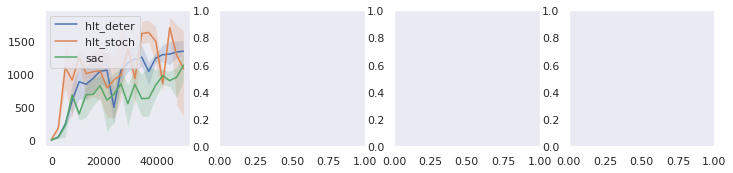

In [9]:
methods = ['hlt_deter','hlt_stoch','sac']
# envs = ['HalfCheetahBulletEnv']
envs = ['HopperBulletEnv']
# envs = ['InvertedPendulumBulletEnv']

fig, axs = plt.subplots(1, 4, figsize=(12,2.5))
path_dir = './data/'
for method in methods:
    for env in envs:
        data_path = path_dir + '/{}/{}/'.format(method, env)
        data = process_data(data_path)
        plot_data(axs[0], data, method)
axs[0].legend()
# axs[0].set_xlim(0, 20000)

/home/burn/.local/lib/python3.6/site-packages/numpy/core/function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/burn/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/burn/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/burn/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/burn/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/burn/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in

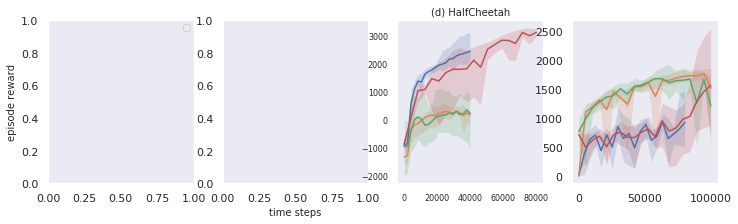

In [6]:
# fig, axs = plt.subplots(2, 4, figsize=(10,4))

fig, axs = plt.subplots(1, 4, figsize=(12,3))

env_list = ['InvertedPendulumSwingupBulletEnv', 'HopperBulletEnv', 'HalfCheetahBulletEnv', 'AntBulletEnv']
names = {
    'PendulumEnv' : '(a) Pendulum \n Swingup',
    'InvertedPendulumSwingupBulletEnv' : '(b) Cartpole \n Swingup',
    'LunarLanderContinuousEnv' : 'Lundar\n Lander',
    'HopperBulletEnv' : '(c) Hopper',
    'HalfCheetahBulletEnv' : '(d) HalfCheetah'
}
# env_list = ['InvertedPendulumSwingupBulletEnv']#, 'InvertedPendulumSwingupBulletEnv', 'LunarLanderContinuousEnv', 'HopperBulletEnv']

path_src = './data/'

for i,env in enumerate(env_list):
    try:
        hlt_stoch_data = process_data(path_src + env + '/hlt_stoch/')
        sac_data = process_data(path_src + env +  '/sac/')
        mppi_data = process_data(path_src + env +  '/mppi/')
        shooting_data = process_data(path_src + env +  '/shooting/')


        plot_data(axs[i], hlt_stoch_data, 'HLT Stoch + SAC')
    #     plot_data(axs[0,i], hdsac_data, 'Ours (Det.)+SAC ')
    #     plot_data(axs[0,i], stoch_model_data, 'Stoch-ModelBased')
        plot_data(axs[i], mppi_data, 'MPPI + NN Model')
        plot_data(axs[i], shooting_data, 'Shooting + NN Model')
        plot_data(axs[i], sac_data, 'SAC')


        axs[i].set_title(names[env], fontsize=10)

        axs[i].tick_params(axis='both', which='major', labelsize=8)
    #     axs[i].tick_params(axis='both', which='minor', labelsize=10)
    #     axs[1,i].tick_params(axis='both', which='major', labelsize=8)


    #     axs[1,i].plot(hdsac_data['x'],hdsac_data['mode_insert'])
    #     axs[1,i].fill_between(hdsac_data['x'], 
    #                     hdsac_data['mi_min'], hdsac_data['mi_max'],
    #                     alpha=0.2)
    except:
        pass
    
    
axs[1].set_xlabel('time steps', fontsize=10)
axs[0].set_ylabel('episode reward', fontsize=10)
axs[0].legend(fontsize=8)

# axs[1,0].set_ylabel('mode insertion \n gradient', fontsize=10)

# axs[0,2].set_ylim(-400, 150)
# axs[1,2].set_xlim(20, 1000)
# plt.tight_layout()

# plt.subplots_adjust(bottom=1, right=1, top=1)

# plt.savefig('deterministic_benchmark_results.pdf')


In [26]:
axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa119e4f60>,
      dtype=object)

[array([   6.70907752,   87.05162646,   87.92700426,  229.84844928,
        191.86394098,  717.6035944 , 1062.79979611,  916.46284703,
       1275.4272972 ,  984.33527915,  433.76596277,  905.21772686,
       1005.09099033,  497.594062  ,  867.32069114,  772.80920085,
        944.96102457,  808.97653922,  807.24087999, 1320.95583842]), array([  10.73856053,   84.07360784,  154.45421852,  180.36718055,
         62.93686689,  583.20034551,  461.32550251,  959.02729733,
       1343.01884907,  816.62727274,  493.79068349,  677.22487079,
        296.78251055,  650.07934099,  905.1408255 , 1242.36695333,
       1110.45001444, 1324.46332228, 1134.14806011,  706.0403192 ]), array([  12.41920107,   25.42534152,  166.33650709,  272.46904441,
        545.33809149,  637.02463822,  196.02340937, 1005.73996212,
       1262.11927831, 1295.82906821, 1320.35194389, 1366.93244175,
       1225.666571  ,  544.53305742, 1163.25984106,  803.60525842,
       1168.31118815, 1467.38150061, 1484.03100216, 1422.

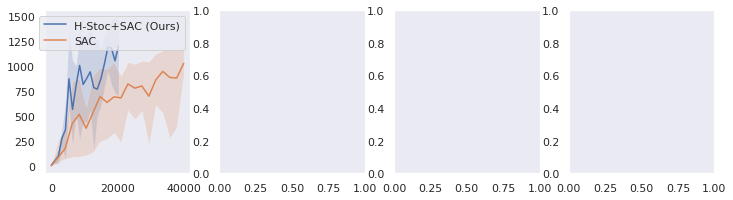

In [31]:
env = 'InvertedPendulumSwingupBulletEnv'
env = 'HopperBulletEnv'
hsac_data = process_data('./examples/data/' + env + '/h_sac/')
# hdsac_data = process_data('./examples/data/' + env + '/hd_sac/')
sac_data = process_data('./examples/data/'+ env +  '/sac/')

# stoch_model_data = process_data('./examples/data/'+ env +  '/stoch_model_based_learning/')
# deter_model_data = process_data('./examples/data/'+ env +  '/deter_model_based_learning/')


fig, axs = plt.subplots(1, 4, figsize=(12,3))
plot_data(axs[i], hsac_data, 'H-Stoc+SAC (Ours)')
#     plot_data(axs[i], hdsac_data, 'H-Det+SAC (Ours)')
# plot_data(axs[i], stoch_model_data, 'Stoch. Model-Based')
#     plot_data(axs[i], deter_model_data, 'Det. Model-Based')
plot_data(axs[i], sac_data, 'SAC')
axs[0].legend()
plt.show()


In [ ]:
pickle.dump(stoch_model_data, open('model_policy_analysis/data/InvertedPendulumSwingupBulletEnv/model_based_results/data.pkl', 'wb'))
pickle.dump(sac_data, open('model_policy_analysis/data/InvertedPendulumSwingupBulletEnv/model_free_results/data.pkl', 'wb'))


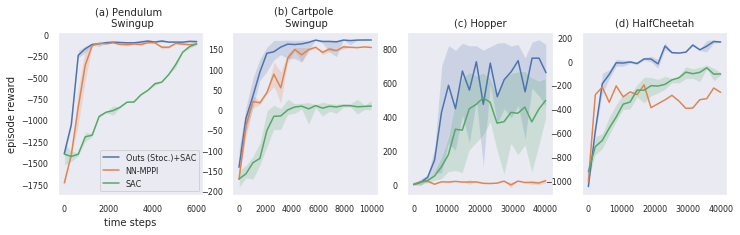

In [17]:
# fig, axs = plt.subplots(2, 4, figsize=(10,4))

fig, axs = plt.subplots(1, 4, figsize=(12,3))

env_list = ['PendulumEnv', 'InvertedPendulumSwingupBulletEnv', 'HopperBulletEnv', 'HalfCheetahBulletEnv']
names = {
    'PendulumEnv' : '(a) Pendulum \n Swingup',
    'InvertedPendulumSwingupBulletEnv' : '(b) Cartpole \n Swingup',
    'LunarLanderContinuousEnv' : 'Lundar\n Lander',
    'HopperBulletEnv' : '(c) Hopper',
    'HalfCheetahBulletEnv' : '(d) HalfCheetah'
}
# env_list = ['InvertedPendulumSwingupBulletEnv']#, 'InvertedPendulumSwingupBulletEnv', 'LunarLanderContinuousEnv', 'HopperBulletEnv']

for i,env in enumerate(env_list):
    hsac_data = process_data('./benchmarks/data/' + env + '/h_sac/')
    hdsac_data = process_data('./benchmarks/data/' + env + '/hd_sac/')
    sac_data = process_data('./benchmarks/data/'+ env +  '/sac/')

    stoch_model_data = process_data('./benchmarks/data/'+ env +  '/stoch_model_based_learning/')
    deter_model_data = process_data('./benchmarks/data/'+ env +  '/deter_model_based_learning/')


    plot_data(axs[i], hsac_data, 'Outs (Stoc.)+SAC')
#     plot_data(axs[i], hdsac_data, 'H-Det+SAC (Ours)')
    plot_data(axs[i], stoch_model_data, 'NN-MPPI')
#     plot_data(axs[i], deter_model_data, 'Det. Model-Based')
    plot_data(axs[i], sac_data, 'SAC')
        

    axs[i].set_title(names[env], fontsize=10)
    
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    
    
axs[0].set_xlabel('time steps', fontsize=10)
axs[0].set_ylabel('episode reward', fontsize=10)
axs[0].legend(fontsize=8)

# axs[0,2].set_ylim(-400, 150)
# axs[1,2].set_xlim(20, 1000)
# plt.tight_layout()

# plt.subplots_adjust(bottom=1, right=1, top=1)

plt.savefig('stochastic_benchmark_results.pdf')


In [5]:
_rew = None
new_mean = []
for m in sac_data['mean']:
    if _rew is None:
        _rew = m
    else:
        if m > _rew:
            _rew = m
    new_mean.append(_rew)

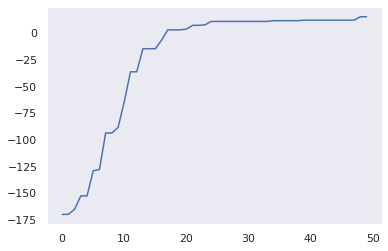

In [6]:
plt.plot(new_mean)

In [1]:
import envs

current_dir=/home/burn/.local/lib/python3.6/site-packages/pybullet_envs/bullet
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
env = envs.env_list['HalfCheetahBulletEnv'](render=True)

In [3]:
env.render("human")

array([], dtype=float64)

In [16]:
env.reset()

array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.2522928 ,  0.        ,
       -0.07460725,  0.        , -0.41312945,  0.        ,  0.22763251,
        0.        ,  0.12707956,  0.        ,  1.208215  ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [21]:
for _ in range(2):
    env.step(env.action_space.sample())